<a href="https://colab.research.google.com/github/chokun7788/PoopforAIB/blob/main/VeryGoodPoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U fastai scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 828.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

###import

In [8]:
from fastai.vision.all import *
import timm
from sklearn.metrics import classification_report,f1_score
from fastai.callback.tracker import SaveModelCallback
import matplotlib.pyplot as plt
import numpy as np

###Path

In [15]:
path = Path('/content/drive/MyDrive/TheRealV1')
train_path = path/'train'
valid_path = path/'valid'
test_path = path/'test'

class_names = ['Blood', 'Diarrhea', 'Normal', 'Mucus', 'Yellow', 'Green']
num_classes = len(class_names)
image_size = 224 #ขนาด(กว้างxยาว)
batch_size = 32 #รูปภาพที่ยัดพร้อมกัน

###Augment

In [16]:
item_tfms = [Resize(image_size,method = ResizeMethod.Squish)]
custom_batch_tfms = aug_transforms(
    do_flip=True, #พลิกแนวนอน
    max_rotate=15.0, #สุ่มหมุน 15องศา
    min_zoom=1.0, #ซูมน้อยสุด
    max_zoom=1.15, #สุ่มซูม
    max_warp=0.15, #สุ่มบิดมุมภาพ
    p_affine=0.75 #สุ่มค.น่าจะเป็น
) + [RandomErasing(p=0.3, sl=0.0, sh=0.25, min_aspect=0.3)] #สุ่มพื้นที่บางส่วนแล้วปรับขนาตาม image_size

###DataLoaders

In [19]:
dls = ImageDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    item_tfms=item_tfms,
    batch_tfms=custom_batch_tfms,
    bs=batch_size,
    seed=42
)
print(f"Classes: {dls.vocab}")
print(f"Number of classes : {dls.c}")

Classes: ['Blood', 'Diarrhea', 'Green', 'Mucus', 'Normal', 'Yellow']
Number of classes : 6


###Model

In [21]:
model_name = 'convnextv2_tiny.fcmae_ft_in22k_in1k'

In [22]:
learn = vision_learner(
    dls,
    model_name,
    metrics=[
        accuracy,
        error_rate,
        F1Score(average='macro'),
    ],
    cbs=[
        SaveModelCallback(
            monitor='f1_score',
            fname='best_f1_checkpoint',
            with_opt=True,
            comp=np.greater
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

###Learning Rate

Suggested learning rates: valley=0.0003981071640737355, slide=0.0008317637839354575


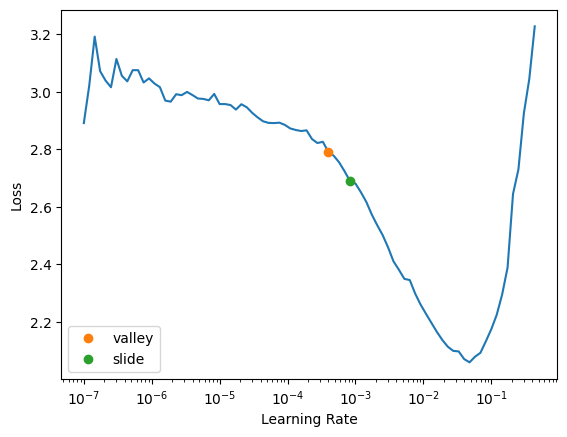

In [23]:
lr_find_results = learn.lr_find(suggest_funcs=(valley, slide))
print(f"Suggested learning rates: valley={lr_find_results.valley}, slide={lr_find_results.slide}")

###Train Model

In [29]:
epochs = 30
freeze = 7
lr = 0.0008317637839354575

In [ ]:
learn.fine_tune(
    epochs,
    base_lr = lr,
    freeze_epochs=freeze
)

epoch,train_loss,valid_loss,accuracy,error_rate,f1_score,time
0,2.670016,1.520035,0.416058,0.583942,0.397082,12:50


Better model found at epoch 0 with f1_score value: 0.3970824194962126.


In [ ]:
learn.recorder.plot_loss()
plt.show()

###Best Model

In [ ]:
best_checkpoint_name = 'best_valid_loss_checkpoint'
checkpoint_path = learn.path/learn.model_dir/f'{best_checkpoint_name}.pth'

In [ ]:
learn.load(best_checkpoint_name)
print(f"Successfully loaded weights from '{best_checkpoint_name}'.")

###Save Model

In [ ]:
save_model_directory = path/'convnextv2_thev1'
save_model_directory.mkdir(parents=True, exist_ok=True)

In [ ]:
model_export_filename = 'convnextv2_thev1_best.pkl
model_export_path = save_model_directory/model_export_filename

learn.export(model_export_path)
print(f"Best Full Learner exported to: {model_export_path}")

###Test Set

In [ ]:
best_model_pkl_path = path/'save_model'/'convnextv2_thev1_best.pkl'
eval_learner = load_learner(best_model_pkl_path)
test_files = get_image_files(test_path).sorted()
test_dl = eval_learner.dls.test_dl(test_files, with_labels=True)

In [ ]:
test_preds_raw, test_targs, test_decoded_preds = eval_learner.get_preds(dl=test_dl, with_decoded=True)
target_names_test = eval_learner.dls.vocab
report_test_dict = classification_report(
  test_targs.numpy(),
  test_decoded_preds.numpy(),
  target_names=target_names_test,
  output_dict=True
)
print(classification_report(
  test_targs.numpy(),
  test_decoded_preds.numpy(),
  target_names=target_names_test
)
)

print(f"Test Set Macro F1-Score (Best Model): {report_test_dict['macro avg']['f1-score']:.4f}")
print(f"Test Set Weighted F1-Score (Best Model): {report_test_dict['weighted avg']['f1-score']:.4f}")

print("Test Set Confusion Matrix (Best Model) ---")
cm_test = ConfusionMatrix(actuals=test_targs.numpy(), preds=test_decoded_preds.numpy())
cm_test.plot(class_names=target_names_test, normalize=True, figsize=(10,10), dpi=70)
plt.title("Test Set Confusion Matrix (Normalized - Best Model)")
plt.show()